# Load the observation data(Generated by the FDM Model)

File successfully loaded: fdm_observation_data.csv
Data shape: (100000, 7)

Column names:
['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']


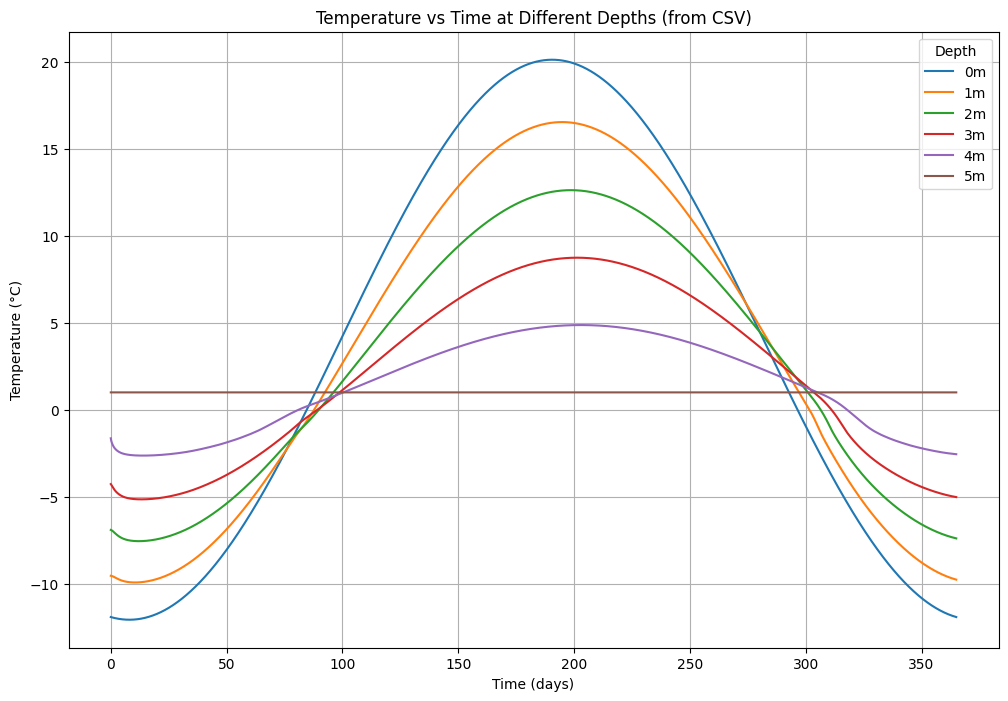


First 5 rows:
   time_days  temperature_0m  temperature_1m  temperature_2m  temperature_3m  \
0    0.00000      -11.926392       -9.552234       -6.914287       -4.276604   
1    0.00365      -11.926532       -9.552312       -6.914457       -4.277133   
2    0.00730      -11.926671       -9.552390       -6.914628       -4.277667   
3    0.01095      -11.926810       -9.552468       -6.914799       -4.278204   
4    0.01460      -11.926949       -9.552546       -6.914971       -4.278746   

   temperature_4m  temperature_5m  
0       -1.641872             1.0  
1       -1.645727             1.0  
2       -1.649533             1.0  
3       -1.653264             1.0  
4       -1.656913             1.0  

Statistical summary:
           time_days  temperature_0m  temperature_1m  temperature_2m  \
count  100000.000000   100000.000000   100000.000000   100000.000000   
mean      182.500000        4.030000        3.370696        2.655721   
std       105.368005       11.391547        9.3692

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
filename = 'fdm_observation_data.csv'
df = pd.read_csv(filename)

# Print basic information
print("File successfully loaded:", filename)
print(f"Data shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Plot temperature vs. time
plt.figure(figsize=(12, 8))

# Find all temperature columns (those containing "temperature")
temp_columns = [col for col in df.columns if 'temperature' in col]

# Plot each column
for col in temp_columns:
    depth = col.split('_')[1]  # extract depth label (e.g., "1m")
    plt.plot(df['time_days'], df[col], label=f'{depth}')

plt.xlabel('Time (days)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Time at Different Depths (from CSV)')
plt.legend(title='Depth')
plt.grid(True)
plt.show()

# Show first 5 rows of data
print("\nFirst 5 rows:")
print(df.head())

# Show statistical summary
print("\nStatistical summary:")
print(df.describe())

# Inversion using PINNs

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.interpolate import interp1d

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Neural network definition
class PhaseChangePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f'linear_{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f'tanh_{i}', nn.Tanh())
        # Parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

class InversionFreezingSoilPINN:
    def __init__(self, known_params, param_bounds, device='cuda'):
        self.device = device
        
        # Known fixed parameters
        self.L = torch.tensor(known_params['L'], device=device)
        self.C_i = torch.tensor(known_params['C_i'], device=device)
        self.C_l = torch.tensor(known_params['C_l'], device=device)
        self.lambda_i = torch.tensor(known_params['lambda_i'], device=device)
        self.lambda_l = torch.tensor(known_params['lambda_l'], device=device)
        
        # Parameters to be estimated — initialize at the midpoint of bounds and set as trainable
        self.param_bounds = param_bounds
        self.param_names = list(param_bounds.keys())
        
        # Initialize using the midpoint of parameter ranges
        self.lambda_f = nn.Parameter(torch.tensor(
            (param_bounds['lambda_f'][0] + param_bounds['lambda_f'][1]) / 2, device=device))
        self.C_f = nn.Parameter(torch.tensor(
            (param_bounds['C_f'][0] + param_bounds['C_f'][1]) / 2, device=device))
        self.eta = nn.Parameter(torch.tensor(
            (param_bounds['eta'][0] + param_bounds['eta'][1]) / 2, device=device))
        self.b = nn.Parameter(torch.tensor(
            (param_bounds['b'][0] + param_bounds['b'][1]) / 2, device=device))
        self.T_nabla = nn.Parameter(torch.tensor(
            (param_bounds['T_nabla'][0] + param_bounds['T_nabla'][1]) / 2, device=device))
        
        # Parameter constraints
        self.param_constraints = {}
        for param_name, (min_val, max_val) in param_bounds.items():
            self.param_constraints[param_name] = (min_val, max_val)
        
        # Neural network (same architecture as forward PINNs)
        self.model = PhaseChangePINN([2, 50, 50, 50, 1]).to(device)
        
        # Optimizer needs to optimize both NN parameters and physical parameters
        self.optimizer = optim.Adam([
            {'params': self.model.parameters(), 'lr': 1e-4},
            {'params': [self.lambda_f, self.C_f, self.eta, self.b, self.T_nabla], 'lr': 1e-5}
        ])
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1000)
        
        # Loss history
        self.loss_history = []
        self.pde_loss_history = []
        self.data_loss_history = []
        self.boundary_loss_history = []
        
        # Parameter history
        self.param_history = {name: [] for name in self.param_names}
        
        # Store boundary condition data
        self.boundary_data = None
        self.T_max = 20.0  # Default value, computed later
        self.boundary_interp_func = None  # Boundary interpolation function

    def apply_param_constraints(self):
        """Apply parameter constraints"""
        with torch.no_grad():
            for param_name, (min_val, max_val) in self.param_constraints.items():
                param = getattr(self, param_name)
                param.data = torch.clamp(param.data, min_val, max_val)

    def get_current_params(self):
        """Get current parameter values"""
        return {
            'lambda_f': self.lambda_f.item(),
            'C_f': self.C_f.item(),
            'eta': self.eta.item(),
            'b': self.b.item(),
            'T_nabla': self.T_nabla.item()
        }

    def _pore_water(self, T):
        """Pore water content calculation (same as forward PINNs)"""
        return torch.where(T >= self.T_nabla,
                          torch.ones_like(T),
                          torch.abs(self.T_nabla)**self.b * torch.abs(T)**(-self.b))

    def _unfrozen_water(self, T):
        """Unfrozen water content calculation (same as forward PINNs)"""
        return self.eta * self._pore_water(T)

    def _effective_heat_capacity(self, T):
        """Effective heat capacity calculation (same as forward PINNs)"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.C_f + self.eta*(phi*self.C_l + (1-phi)*self.C_i)

    def _effective_conductivity(self, T):
        """Effective thermal conductivity calculation (same as forward PINNs)"""
        phi = self._pore_water(T)
        return (1-self.eta)*self.lambda_f + self.eta*(phi*self.lambda_l + (1-phi)*self.lambda_i)

    def _create_boundary_interp_func(self):
        """Create boundary interpolation function"""
        if self.boundary_data is not None:
            time_points = self.boundary_data['time_days'].values
            temp_values = self.boundary_data['temperature_0m'].values
            # Create linear interpolation function
            self.boundary_interp_func = interp1d(time_points, temp_values, 
                                                kind='linear', bounds_error=False, 
                                                fill_value="extrapolate")
        else:
            self.boundary_interp_func = None

    def _boundary_temp(self, t):
        """Upper boundary temperature function (x=0) — read surface temperature directly from CSV"""
        # Handle tensor input
        if isinstance(t, torch.Tensor):
            t_np = t.detach().cpu().numpy().flatten()
            
            if self.boundary_interp_func is not None:
                # Use interpolation function
                temp_values = self.boundary_interp_func(t_np)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
            else:
                # If no boundary data, use default
                temp_values = 4.03 + 16.11*np.sin(2*np.pi*t_np/365 - 1.709)
                return torch.tensor(temp_values / self.T_max, dtype=torch.float32, device=self.device).unsqueeze(1)
        else:
            # Scalar input
            t_scalar = t
            
            if self.boundary_interp_func is not None:
                return self.boundary_interp_func(t_scalar) / self.T_max
            else:
                return (4.03 + 16.11*np.sin(2*np.pi*t_scalar/365 - 1.709)) / self.T_max

    def compute_physics_loss(self, x, t):
        """Compute physics-constrained loss (same formulation as forward PINNs)"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Compute gradients
        dT_dt = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred), 
                                   create_graph=True, retain_graph=True)[0]
        dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred),
                                   create_graph=True, retain_graph=True)[0]
        d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx),
                                     create_graph=True, retain_graph=True)[0]
        
        # Material property calculations
        C_eff = self._effective_heat_capacity(T_pred)
        lambda_eff = self._effective_conductivity(T_pred)
        theta = self._unfrozen_water(T_pred)
        dtheta_dt = torch.autograd.grad(theta, t, grad_outputs=torch.ones_like(theta),
                                       create_graph=True, retain_graph=True)[0]
        
        # PDE residual (same as forward PINNs)
        pde_res = C_eff*dT_dt - lambda_eff*d2T_dx2 - self.L*dtheta_dt
        pde_loss = torch.mean(pde_res**2)
        
        return pde_loss

    def compute_data_loss(self, x_obs, t_obs, T_obs_true):
        """Compute observation data loss"""
        T_pred = self.model(torch.cat([x_obs, t_obs], dim=1))
        data_loss = torch.mean((T_pred - T_obs_true)**2)
        return data_loss

    def compute_boundary_loss(self, x, t):
        """Compute boundary condition loss"""
        T_pred = self.model(torch.cat([x, t], dim=1))
        
        # Upper boundary condition (x=0)
        bc0_mask = (x == 0).squeeze()
        bc0_loss = torch.tensor(0.0, device=self.device)
        if bc0_mask.any():
            bc0_pred = T_pred[bc0_mask]
            bc0_true = self._boundary_temp(t[bc0_mask])
            bc0_loss = torch.mean((bc0_pred - bc0_true)**2)
        
        # Lower boundary condition (x=5)
        bcL_mask = (x == 5).squeeze()
        bcL_loss = torch.tensor(0.0, device=self.device)
        if bcL_mask.any():
            bcL_pred = T_pred[bcL_mask]
            bcL_true = torch.ones_like(bcL_pred) * (1.0 / self.T_max)  # Lower boundary 1°C, normalized
            bcL_loss = torch.mean((bcL_pred - bcL_true)**2)
        
        return bc0_loss + bcL_loss

    def train(self, x_domain, t_domain, x_obs, t_obs, T_obs_true, epochs=30000):
        print("Start inversion training...")
        print(f"Intialized parameters: {self.get_current_params()}")
        
        # Compute T_max — get maximum directly from CSV data
        if self.boundary_data is not None:
            # Compute maximum over all depths
            temp_columns = [col for col in self.boundary_data.columns if col.startswith('temperature_')]
            self.T_max = self.boundary_data[temp_columns].max().max()
            # Create boundary interpolation function
            self._create_boundary_interp_func()
        else:
            # If no boundary data, use max of default boundary function
            t_test = np.linspace(t_domain[0], t_domain[1], 1000)
            boundary_temps = [4.03 + 16.11*np.sin(2*np.pi*t_val/365 - 1.709) for t_val in t_test]
            self.T_max = max(boundary_temps)
        
        print(f"T_max (scaling factor): {self.T_max}")
        
        # Generate training data points (same sampling strategy as forward PINNs)
        n_samples = 10000
        x = torch.rand(n_samples, 1, device=self.device) * (x_domain[1] - x_domain[0]) + x_domain[0]
        t = torch.rand(n_samples, 1, device=self.device) * (t_domain[1] - t_domain[0]) + t_domain[0]
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        # Add boundary points (enforced sampling)
        bc0_points = torch.zeros(500, 1, device=self.device)
        bc0_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        bcL_points = torch.ones(500, 1, device=self.device)*5.0
        bcL_times = torch.rand(500, 1, device=self.device)*t_domain[1]
        
        x = torch.cat([x, bc0_points, bcL_points])
        t = torch.cat([t, bc0_times, bcL_times])
        
        # Training loop
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            
            # Compute losses
            physics_loss = self.compute_physics_loss(x, t)
            data_loss = self.compute_data_loss(x_obs, t_obs, T_obs_true)
            boundary_loss = self.compute_boundary_loss(x, t)
            
            # Adjust loss weights; give higher weight to data loss
            total_loss = (1e2 * physics_loss + 
                        1e2 * boundary_loss + 
                        1e5 * data_loss)  # Data loss has the highest weight
            
            total_loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            # Apply parameter constraints
            self.apply_param_constraints()
            
            # Record losses and parameters
            self.loss_history.append(total_loss.item())
            self.pde_loss_history.append(physics_loss.item())
            self.data_loss_history.append(data_loss.item())
            self.boundary_loss_history.append(boundary_loss.item())
            
            current_params = self.get_current_params()
            for name in self.param_names:
                self.param_history[name].append(current_params[name])
            
            # Progress print
            if epoch % 1000 == 0:
                print(f'Epoch {epoch:5d}, Total Loss: {total_loss.item():.3e}')
                print(f'  Physics: {physics_loss.item():.3e}, Data: {data_loss.item():.3e}, Boundary: {boundary_loss.item():.3e}')
                print(f'  Current params: {current_params}')
                
        return self.loss_history

    def predict(self, x, t):
        with torch.no_grad():
            xt = torch.cat([x, t], dim=1)
            return self.model(xt) * self.T_max  # Denormalize

def load_fdm_data_from_csv(csv_file='fdm_observation_data.csv'):
    """Load FDM observation data from a CSV file"""
    df = pd.read_csv(csv_file)
    
    print(f" From {csv_file} loading data successfully ")
    print(f"Data Shape: {df.shape}")
    print(f"Colunmn name: {list(df.columns)}")
    
    # Extract time data
    t_days = df['time_days'].values
    
    # Extract temperature data
    temperature_data = {}
    obs_depths = []
    
    for col in df.columns:
        if col.startswith('temperature_'):
            # Extract depth value
            depth_str = col.replace('temperature_', '').replace('m', '')
            depth = float(depth_str)
            obs_depths.append(depth)
            temperature_data[depth] = df[col].values
    
    print(f"Depth: {sorted(obs_depths)}m")
    print(f"Time length: {len(t_days)}")
    print(f"Time range: {t_days[0]:.1f} to {t_days[-1]:.1f} days")
    
    return df, t_days, temperature_data, obs_depths

def prepare_observation_data_from_csv(csv_file='fdm_observation_data.csv'):
    """Prepare observation data from CSV for inversion"""
    df, t_days, temperature_data, obs_depths = load_fdm_data_from_csv(csv_file)
    
    # Compute max temperature for normalization
    all_temps = np.concatenate([temperature_data[depth] for depth in obs_depths])
    T_max = np.max(all_temps)
    
    # Build observation tensors
    x_obs_list = []
    t_obs_list = []
    T_obs_list = []
    
    for depth in obs_depths:
        temp_vals = temperature_data[depth]
        for i, t_val in enumerate(t_days):
            x_obs_list.append([depth])
            t_obs_list.append([t_val])
            T_obs_list.append([temp_vals[i] / T_max])  # Normalize
    
    x_obs = torch.tensor(x_obs_list, dtype=torch.float32)
    t_obs = torch.tensor(t_obs_list, dtype=torch.float32)
    T_obs = torch.tensor(T_obs_list, dtype=torch.float32)
    
    print(f"Obs data shape: x_obs={x_obs.shape}, t_obs={t_obs.shape}, T_obs={T_obs.shape}")
    print(f"Normalized temperature range: {T_obs.min():.4f} to {T_obs.max():.4f}")
    
    return df, x_obs, t_obs, T_obs, obs_depths, T_max

def plot_inversion_results(inversion_model, true_params=None):
    """Plot inversion results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss curves
    ax = axes[0, 0]
    ax.semilogy(inversion_model.loss_history, label='Total Loss')
    ax.semilogy(inversion_model.pde_loss_history, label='Physics Loss')
    ax.semilogy(inversion_model.data_loss_history, label='Data Loss')
    ax.semilogy(inversion_model.boundary_loss_history, label='Boundary Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_title('Training Loss')
    ax.grid(True)
    
    # Parameter evolution
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for idx, param_name in enumerate(inversion_model.param_names):
        ax = axes[(idx+1)//3, (idx+1)%3]
        param_history = inversion_model.param_history[param_name]
        ax.plot(param_history, color=colors[idx], label='Estimated')
        
        # True value (if known)
        if true_params and param_name in true_params:
            ax.axhline(y=true_params[param_name], color=colors[idx], 
                      linestyle='--', label='True', alpha=0.7)
        
        # Parameter bounds
        min_val, max_val = inversion_model.param_bounds[param_name]
        ax.axhline(y=min_val, color='gray', linestyle=':', alpha=0.5, label='Bounds')
        ax.axhline(y=max_val, color='gray', linestyle=':', alpha=0.5)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(param_name)
        ax.legend()
        ax.set_title(f'{param_name} Evolution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final parameters
    final_params = inversion_model.get_current_params()
    print("\n Final inverted parameters:")
    for param_name in inversion_model.param_names:
        true_val = true_params.get(param_name, None) if true_params else None
        estimated_val = final_params[param_name]
        if true_val is not None:
            error = abs(estimated_val - true_val) / true_val * 100
            print(f"{param_name}: Estimated values={estimated_val:.3f}, Real values={true_val:.3f}, Errors={error:.1f}%")
        else:
            print(f"{param_name}: {estimated_val:.3f}")

def validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max):
    """Validate inversion results"""
    print("\n Final inverted values...")
    
    # Predict using inverted parameters
    with torch.no_grad():
        T_pred = inversion_model.predict(x_obs, t_obs)  # Already denormalized
    
    # Denormalize ground truth
    T_obs_true_denorm = T_obs_true * T_max
    
    # Compute prediction error
    pred_error = torch.abs(T_pred - T_obs_true_denorm)
    mean_error = torch.mean(pred_error).item()
    max_error = torch.max(pred_error).item()
    
    print(f"Error - Mean: {mean_error:.4f}°C, Max: {max_error:.4f}°C")
    
    # Error by depth
    print("\n Error over depths:")
    unique_depths = torch.unique(x_obs).cpu().numpy()
    
    for depth in unique_depths:
        depth_mask = (x_obs == depth).squeeze()
        depth_errors = pred_error[depth_mask]
        depth_mean_error = torch.mean(depth_errors).item()
        depth_max_error = torch.max(depth_errors).item()
        print(f"Depths {depth}m - Mean error: {depth_mean_error:.4f}°C, Max error: {depth_max_error:.4f}°C")
    
    # Plot predicted vs true
    plt.figure(figsize=(15, 10))
    
    # Subplots for each depth
    for i, depth in enumerate(sorted(unique_depths)):
        depth_mask = (x_obs == depth).squeeze()
        depth_t = t_obs[depth_mask].cpu().numpy()
        depth_T_true = T_obs_true_denorm[depth_mask].cpu().numpy()
        depth_T_pred = T_pred[depth_mask].cpu().numpy()
        
        plt.subplot(2, 3, i+1)
        plt.plot(depth_t, depth_T_true, 'b-', label='True', alpha=0.7, linewidth=1.5)
        plt.plot(depth_t, depth_T_pred, 'r--', label='Predicted', alpha=0.7, linewidth=1.5)
        plt.title(f'Depth {depth}m')
        plt.xlabel('Time (days)')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    # Known parameters
    known_params = {
        'L': 3.34e5,
        'C_i': 1.672,
        'C_l': 4.18,
        'lambda_i': 2.210,
        'lambda_l': 0.465
    }
    
    # Parameter bounds should allow variability
    param_bounds = {
        'lambda_f': [1.5, 1.5],    # Thermal conductivity of soil matrix
        'C_f': [1.5, 1.5],         # Heat capacity of soil matrix
        'eta': [0.3, 0.5],         # Porosity
        'b': [1.0, 2],           # Coefficient for unfrozen water
        'T_nabla': [-1.5, -0.5]    # Freezing temperature
    }
    
    # True parameter values (for validation)
    true_params = {
        'lambda_f': 1.5,
        'C_f': 1.5,
        'eta': 0.4,
        'b': 1.5,
        'T_nabla': -1.0
    }
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    
    # Load observation data from CSV
    try:
        df, x_obs, t_obs, T_obs_true, obs_depths, T_max = prepare_observation_data_from_csv('fdm_observation_data.csv')
    except Exception as e:
        print(f" Loading CSV data failure: {e}")
        print("Clarify the CSV data format")
        return
    
    # Move data to device
    x_obs = x_obs.to(device)
    t_obs = t_obs.to(device)
    T_obs_true = T_obs_true.to(device)
    
    # Initialize inversion model
    inversion_model = InversionFreezingSoilPINN(known_params, param_bounds, device)
    
    # Pass boundary data to model
    inversion_model.boundary_data = df
    
    # Train inversion model
    loss_history = inversion_model.train(
        x_domain=(0.0, 5.0),
        t_domain=(0.0, 365.0),
        x_obs=x_obs,
        t_obs=t_obs,
        T_obs_true=T_obs_true,
        epochs=100000
    )
    
    # Plot inversion results
    plot_inversion_results(inversion_model, true_params)
    
    # Validate inversion results
    validate_inversion_results(inversion_model, x_obs, t_obs, T_obs_true, obs_depths, T_max)


Device: cuda
 From fdm_observation_data.csv loading data successfully 
Data Shape: (100000, 7)
Colunmn name: ['time_days', 'temperature_0m', 'temperature_1m', 'temperature_2m', 'temperature_3m', 'temperature_4m', 'temperature_5m']
Depth: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]m
Time length: 100000
Time range: 0.0 to 365.0 days
Obs data shape: x_obs=torch.Size([600000, 1]), t_obs=torch.Size([600000, 1]), T_obs=torch.Size([600000, 1])
Normalized temperature range: -0.5998 to 1.0000
Start inversion training...
Intialized parameters: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.4000000059604645, 'b': 1.5, 'T_nabla': -1.0}
T_max (scaling factor): 20.139999994384475
Epoch     0, Total Loss: 2.077e+04
  Physics: 5.045e-04, Data: 2.072e-01, Boundary: 4.808e-01
  Current params: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0.3999899923801422, 'b': 1.5, 'T_nabla': -1.0}
Epoch  1000, Total Loss: 4.962e+03
  Physics: 1.159e-03, Data: 4.948e-02, Boundary: 1.422e-01
  Current params: {'lambda_f': 1.5, 'C_f': 1.5, 'eta': 0

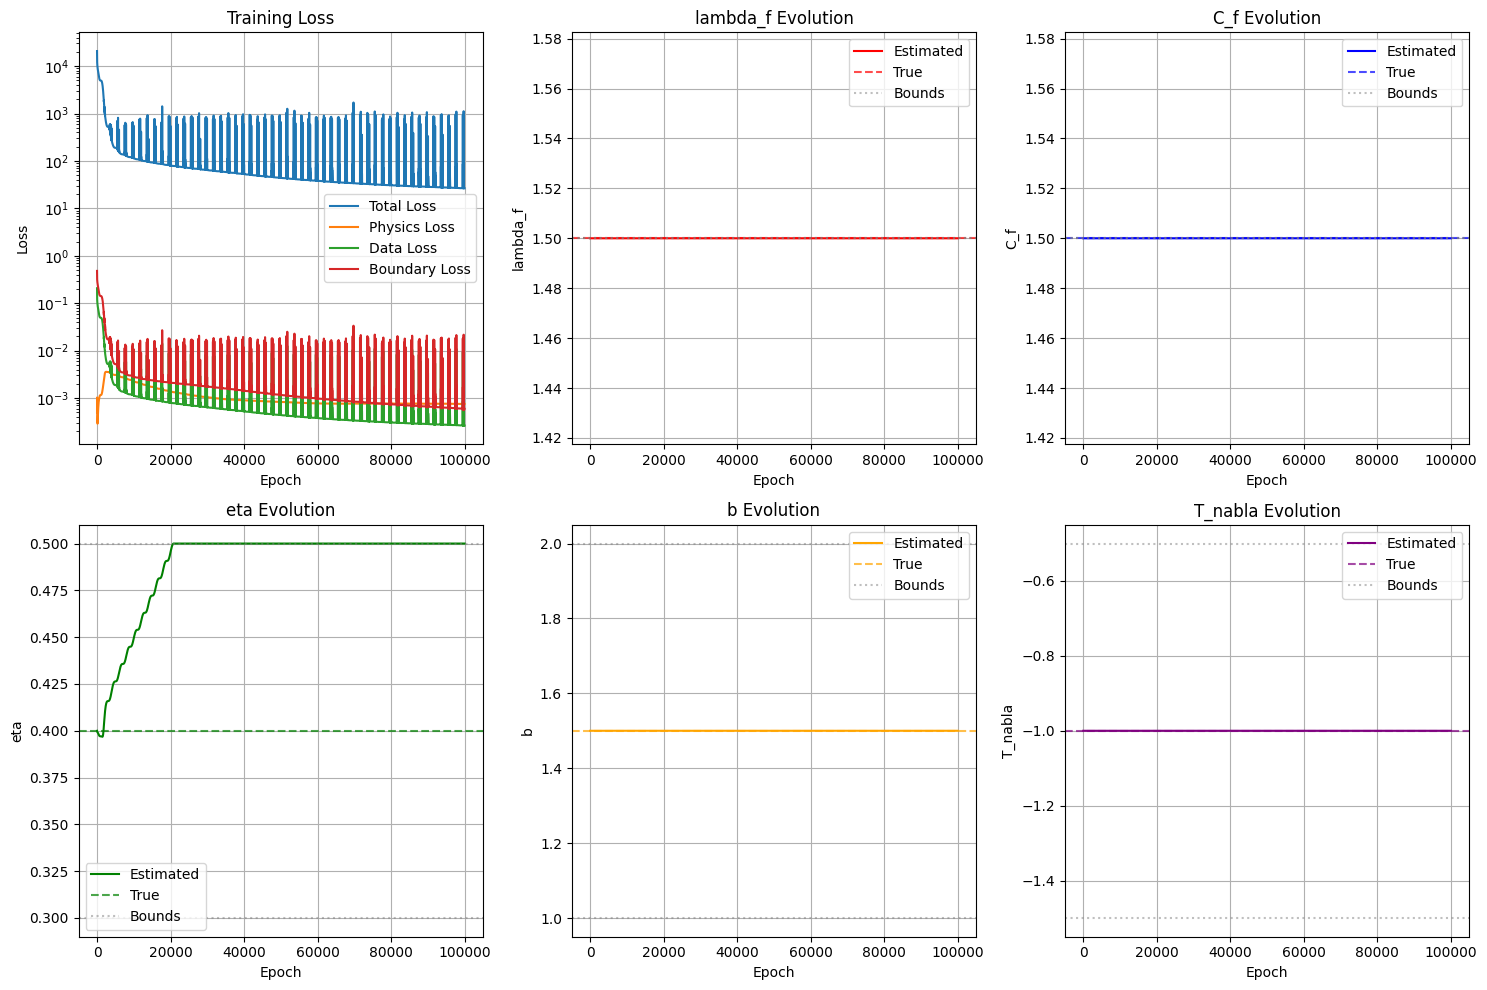


 Final inverted parameters:
lambda_f: Estimated values=1.500, Real values=1.500, Errors=0.0%
C_f: Estimated values=1.500, Real values=1.500, Errors=0.0%
eta: Estimated values=0.500, Real values=0.400, Errors=25.0%
b: Estimated values=1.500, Real values=1.500, Errors=0.0%
T_nabla: Estimated values=-1.000, Real values=-1.000, Errors=-0.0%

 Final inverted values...
Error - Mean: 0.2146°C, Max: 1.9400°C

 Error over depths:
Depths 0.0m - Mean error: 0.2563°C, Max error: 1.9400°C
Depths 1.0m - Mean error: 0.2530°C, Max error: 1.6706°C
Depths 2.0m - Mean error: 0.2077°C, Max error: 1.2655°C
Depths 3.0m - Mean error: 0.1665°C, Max error: 0.9136°C
Depths 4.0m - Mean error: 0.2250°C, Max error: 0.8639°C
Depths 5.0m - Mean error: 0.1794°C, Max error: 1.5157°C


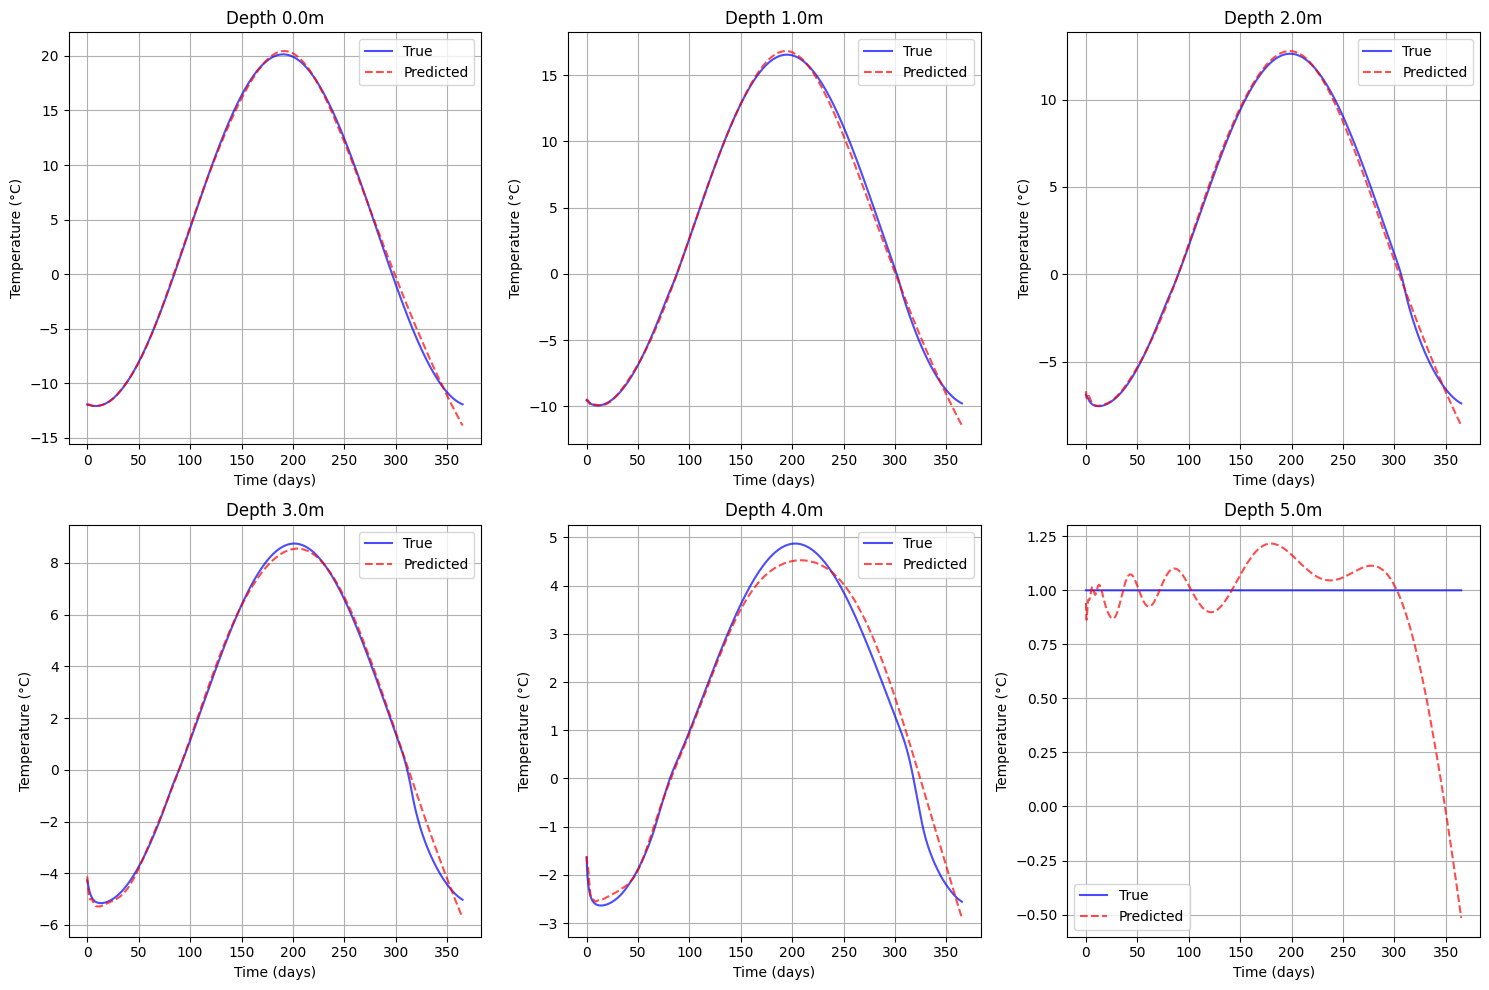

In [5]:
if __name__ == "__main__":
    main()